<img src="https://github.com/bigdata-icict/ETL-Dataiku-DSS/raw/master/tutoriais/identidade_visual.png">

# Sistema de Informações de Mortalidade - SIM

Neste notebook, iremos demonstrar como acessar os dados do SIM indexados pela Plataforma de Ciência de Dados aplicada à Saúde (PCDaS) através do Python.

Os dados do SIM estão disponíveis em um índice do ElasticSearch (ES), que contém todos os registros individuais das declarações de óbito.

## Pacotes necessários

O acesso ao índice no ES é realizado através do pacote [`elastic`](https://cran.r-project.org/web/packages/elastic/elastic.pdf).

In [1]:
from elasticsearch import Elasticsearch, helpers

Vamos também utilizar outras bibliotecas do Python para facilitar a manipulação dos dados obtidos.

In [2]:
#!pip install --user pandasticsearch==0.4.3
from pandasticsearch import Select, Agg

## Acesso ao ElasticSearch

O primeiro passo é informar ao Python os parâmetros de conexão com o índice no ES. Para isso, vamos usar a função `Elasticsearch` da blilioteca `elasticsearch`.

Nos parâmetros `es_user` e `es_pwd`, informe o mesmo usuário e senha que você usar para acessar a plataforma.

Importante lembrar que esta conexão irá funcionar apenas através de notebooks do `Jupyter` rodando dentro da plataforma.

In [3]:
es_host = "dados-pcdas.icict.fiocruz.br"
es_port = "443"
es_transport_schema  = "https"
es_user = "aluno.treinamento"
es_pwd = "aluno123456"
        
# Conexao ao ES
es = Elasticsearch(es_transport_schema+'://'+es_user+':'+es_pwd+'@'+es_host+':'+es_port+'/')

Podemos testar a conexão pedindo algumas informações básicas sobre o ElasticSearch.

In [4]:
es.info()

{'name': 'elastic1',
 'cluster_name': 'elastic.fiocruz.lncc.br',
 'cluster_uuid': 'RCB_nTLkTeGEKgF7osqmDw',
 'version': {'number': '6.3.0',
  'build_flavor': 'default',
  'build_type': 'deb',
  'build_hash': '424e937',
  'build_date': '2018-06-11T23:38:03.357887Z',
  'build_snapshot': False,
  'lucene_version': '7.3.1',
  'minimum_wire_compatibility_version': '5.6.0',
  'minimum_index_compatibility_version': '5.0.0'},
 'tagline': 'You Know, for Search'}

Podemos ver acima, por exemplo, que a versão do `ElasticSearch` utilizada atualmente é a 6.3.0.

## Primeiras informações

Com os comandos abaixo iremos obter algumas informações básicas do índice do SIM.

O comando `count` irá dizer quantos registros existem no banco do SIM. No jargão do ElasticSearch, podemos dizer: "quantos documentos existem no índice".

O argumento `index` define o nome do índice a ser consultado.

In [5]:
es.count(index="datasus-sim-dss")

{'count': 22366860,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}

O comando `get_mapping` retorna o mapeamento das variáveis, ou seja, quais variáveis existem no índice e seus tipos. Lembrando que as variáveis em letras maiúsculas são originais das declarações de óbito disponibilizadas pelo [DATASUS](http://www2.datasus.gov.br/DATASUS/index.php?area=060701) e as variáveis em letras minúsculas foram geradas pela equipe PCDaS. Não deixe de conferir o [dicionário de dados](https://bigdata-metadados.icict.fiocruz.br/dataset/sistema-de-informacoes-de-mortalidade-sim) do SIM antes de trabalhar com esses dados.

In [6]:
mapping = es.indices.get_mapping(index = "datasus-sim-dss")

## Qual é a cara dos dados?

Podemos ver alguns documentos (registros) do índice (banco do SIM) com o comando `search`.

Além do índice, este comando recebe a definição da consulta que se quer executar. Esta definição é feita utilizando-se o formato [Query DSL](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html). O código abaixo define uma consulta que retorna todos os documentos do índice, sem restrições.

In [7]:
tudo = '{"query": {"match_all": {}}}'

Essa definição de consulta é passada ao comando no argumento `body`. O argumento `size`, por sua vez, define quantos documentos devem ser retornados.
Como padrão são retornados os primeiros 10 documentos do índice. Isso já é o bastante para termos uma ideia da cara dos dados. Entretanto, podemos requisitar até os 10.000 primeiros resultados. Vamos ver mais a frente que dificilmente iremos precisar mais do que isso, pois iremos trabalhar com agregações.

Com isso, a consulta definida na variável `tudo` pode ser executada com o código abaixo.

In [8]:
res = es.search(index="datasus-sim-dss", body=tudo, size=10)

O resultado da consulta, `res`, é retornado em um formato JSON produzido pelo ES. Este resultado pode ser convertido em um `dataframe`, para facilitar a manipulação dos dados, a execução de análises e produção de gráficos. A seguinte função auxiliar executa essa conversão. O argumento `agg` informa se os resultados estão agregados ou não. Como padrão a função considera que não houve agregação. 

In [9]:
def to_df(es_res, agg=False):
    if(agg):
        return Agg.from_dict(es_res).to_pandas()
    else:
        return Select.from_dict(es_res).to_pandas()

O resultado da consulta em formato `dataframe` é obtido com a simples chamada:

In [10]:
to_df(res)

,ACIDTRAB,ALTCAUSA,ASSISTMED,ATESTADO,ATESTANTE,CAUSABAS,CAUSABAS_O,CAUSAMAT,CB_PRE,CIRCOBITO,...,res_LATITUDE,res_LONGITUDE,res_MSAUDCOD,res_MUNNOME,res_MUNNOMEX,res_NOME_UF,res_RSAUDCOD,res_SIGLA_UF,res_codigo_adotado,res_coordenadas
0,None,None,1.0,None,None,E142,None,None,None,9,...,-22.315,-49.061,3590,Bauru,BAURU,SAO PAULO,3510,SP,350600,"-22.31500,-49.06100"
1,None,None,1.0,None,None,I251,None,None,None,9,...,-22.469,-48.988,3590,Agudos,AGUDOS,SAO PAULO,3510,SP,350070,"-22.46900,-48.98800"
2,None,None,2.0,None,None,X959,None,None,None,3,...,-22.315,-49.061,3590,Bauru,BAURU,SAO PAULO,3510,SP,350600,"-22.31500,-49.06100"
3,None,None,1.0,None,None,L024,None,None,None,9,...,-23.548,-46.636,3590,São Paulo,SAO PAULO,SAO PAULO,3501,SP,355030,"-23.54800,-46.63600"
4,None,None,1.0,None,None,I64,None,None,None,9,...,-23.548,-46.636,3590,São Paulo,SAO PAULO,SAO PAULO,3501,SP,355030,"-23.54800,-46.63600"
5,None,None,1.0,None,None,I500,None,None,None,9,...,-23.548,-46.636,3590,São Paulo,SAO PAULO,SAO PAULO,3501,SP,355030,"-23.54800,-46.63600"
6,None,None,1.0,None,None,I709,None,None,None,9,...,-23.548,-46.636,3590,São Paulo,SAO PAULO,SAO PAULO,3501,SP,355030,"-23.54800,-46.63600"
7,None,None,NaN,None,None,I64,None,None,None,9,...,-23.620,-45.413,3590,Caraguatatuba,CARAGUATATUBA,SAO PAULO,3521,SP,351050,"-23.62000,-45.41300"
8,None,None,1.0,None,None,C109,None,None,None,9,...,-23.620,-45.413,3590,Caraguatatuba,CARAGUATATUBA,SAO PAULO,3521,SP,351050,"-23.62000,-45.41300"
9,None,None,1.0,None,None,I64,None,None,None,9,...,-23.620,-45.413,3590,Caraguatatuba,CARAGUATATUBA,SAO PAULO,3521,SP,351050,"-23.62000,-45.41300"


Nos próximos passos, iremos usar outros resultados da função `search`.

### Campos específicos

Na busca acima, estamos vendo todos os campos que existem no índice, inclusive campos criados pelo próprio ES durante a indexação. Podemos modificar essa consulta e solicitar apenas alguns campos de interesse.

In [11]:
campos = '{"_source": ["res_SIGLA_UF", "res_MUNNOME", "CAUSABAS", "causabas_subcategoria"]}'

res = es.search(index = "datasus-sim-dss", body = campos)

to_df(res).drop(['_index', '_type', '_id', '_score'], axis=1)

,CAUSABAS,causabas_subcategoria,res_MUNNOME,res_SIGLA_UF
0,E142,E14.2 C/compl renais,Bauru,SP
1,I251,I25.1 Doenc aterosclerotica do coracao,Agudos,SP
2,X959,X95.9 Local NE,Bauru,SP
3,L024,L02.4 Abscesso cutaneo furunculo e antraz membros,São Paulo,SP
4,I64,I64 Acid vasc cerebr NE como hemorrag isquemico,São Paulo,SP
5,I500,I50.0 Insuf cardiaca congestiva,São Paulo,SP
6,I709,I70.9 Aterosclerose generalizada e a NE,São Paulo,SP
7,I64,I64 Acid vasc cerebr NE como hemorrag isquemico,Caraguatatuba,SP
8,C109,C10.9 Orofaringe NE,Caraguatatuba,SP
9,I64,I64 Acid vasc cerebr NE como hemorrag isquemico,Caraguatatuba,SP


Observe o argumento `body`. Estamos especificando neste parâmetro quais campos queremos ver. Por padrão o ES sempre retorna os campos de indexação, por isso estamos eliminando essas variáveis através do comando `drop`. Iremos explorar mais o argumento `body` nos próximos passos.

## Filtrando resultados

Podemos pedir na busca que o ES filtre os resultados de acordo com algumas variáveis. Por exemplo, quantas pessoas vieram a óbito por um determinado código CID-10. Para isso, usamos o argumento `q`. Este argumento é comum ao comandos `search` e `count`.

In [12]:
es.count(index = "datasus-sim-dss", q="CAUSABAS:I500")['count']

310338

O que significa este resultado? Considerando todos os registros de todos os anos que estão no índice, 310.338 pessoas vieram a óbito com a causa básica I500 (Insuficiência cardíaca congestiva).

Quantas pessoas morreram desta mesma causa básica no ano de 2016?

In [13]:
es.count(index = "datasus-sim-dss", q="CAUSABAS:I500 AND ano_obito:2016")['count']

13661

Quantas pessoas morreram desta mesma causa básica no ano de 2016 no Rio de Janeiro?

In [14]:
es.count(index = "datasus-sim-dss", q="CAUSABAS:I500 AND ano_obito:2016 AND res_SIGLA_UF:RJ")['count']

1323

Quantas pessoas morreram desta mesma causa básica no ano de 2016 em Minas Gerais e Rio de Janeiro?

In [15]:
es.count(index = "datasus-sim-dss", q="CAUSABAS:I500 AND ano_obito:2016 AND (res_SIGLA_UF:RJ OR res_SIGLA_UF:MG)")['count']

2945

Perceba que estamos realizando contagens em mais de 22 milhões registros. Fazer este tipo de contagem em um computador comum poderia durar horas ou dias. Utilizando o ElasticSearch, isso é feito em menos de 1 segundo.

## Agregando resultados

Através de filtros, podemos obter rapidamente algumas contagens, mas se quisermos gerar tabelas mais complexas de contagens, podemos usar uma forma específica para pedir agregações de resultados. 

Por exemplo, quantas pessoas vieram a óbito por estado? Na forma anterior, teríamos que fazer uma consulta para cada estado. Podemos obter o mesmo resultado especificando uma agregação.

Uma agregação para o ES precisa ser escrita seguindo um padrão. Veja abaixo:

In [16]:
agg = {
    "size": 0,
    "aggs": {
        "UF": {
            "terms": {
                "field": "res_SIGLA_UF",
                "size": 27
            }
        }
    }
}

Estamos criando um objeto (dicionário) chamado `agg`, que será usado na consulta ao ES. O que significa cada linha desse objeto?
* `aggs`: isso declara ao ES que você está requerindo uma agregação, não modifique essa linha;
* `UF`: nome da agregação, você pode modificar esse nome;
* `terms`: isso declara ao ES que você quer fazer a agregação a partir de uma variável categórica, resultando naa contagem de documentos. Não modifique essa linha;
* `field`: esse será o campo que você deseja fazer a agregação, no nosso caso, por sigla de UF. Você pode modificar esta linha para outra variável categórica;
* `size`: esse é o limite de resultados da agregação. Como temos 27 estados, podemos especificar o tamanho 27. Se colocarmos um tamanho maior, não irá causar nenhum erro. Se o campo de agregação fosse o nome de municípios, devemos usar um número maior (exemplo: 6.000) para obter os resultados de todos os municípios. O limite deste parâmetro é 10.000.

Veja abaixo o resultado desta busca:

In [17]:
res = es.search(index = "datasus-sim-dss", body = agg)

to_df(res, agg=True)

,doc_count
UF,
SP,5312966
RJ,2551434
MG,2342315
RS,1559442
BA,1453919
PR,1302757
PE,1145371
CE,879679
SC,671381


Observe que agora informamos à função `to_df` que os resultados estão agregados para a correta conversão em `dataframe`. O resultado dessa consulta pode ser guardado para uso posterior em análises e elaboração de gráficos.

In [18]:
df_uf = to_df(res, agg=True)

df_uf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27 entries, (SP,) to (RR,)
Data columns (total 1 columns):
doc_count    27 non-null int64
dtypes: int64(1)
memory usage: 510.0+ bytes


O comando abaixo retorna um gráfico de barras gerado com base nos dados em `df_uf`.

<Figure size 432x288 with 0 Axes>

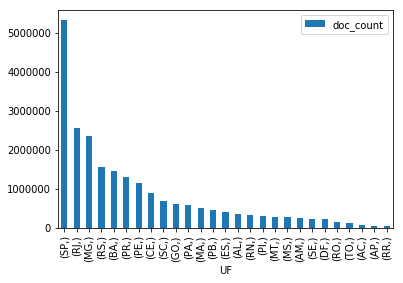

In [20]:
import matplotlib.pyplot as plt

plt.figure()

df_uf.plot.bar()

### Agregando com filtros

Na busca acima, temos o total de óbitos por estado para todos os anos e todas as doenças, sem filtros. Podemos tornar essa busca mais precisa incluindo um filtro.

In [21]:
res = es.search(index="datasus-sim-dss", q = "CAUSABAS:I500 AND ano_obito:2016",body = agg)

to_df(res, agg=True)

,doc_count
UF,
SP,3336
MG,1622
RJ,1323
PR,1100
BA,938
RS,766
SC,517
CE,516
GO,504


Agora temos o total de óbitos por estado para o CID I500 no ano de 2016. Note que estamos usando o mesmo objeto de agregação `agg`. O filtro é informado através do parâmetro `q`.

Podemos agora fazer a mesma busca, agregando por municípios. Precisamos apenas alterar o objeto `agg` e rodar novamente a busca.

In [22]:
agg = {
    "size": 0,
    "aggs": {
        "Municipio": {
            "terms": {
                "field": "res_codigo_adotado",
                "size": 6000
            }
        }
    }
}       

In [23]:
res = es.search(index="datasus-sim-dss", q = "CAUSABAS:I500 AND ano_obito:2016",body = agg)

to_df(res, agg=True).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3192 entries, (355030,) to (522230,)
Data columns (total 1 columns):
doc_count    3192 non-null int64
dtypes: int64(1)
memory usage: 56.2+ KB


### Agregações mais complexas

Essa sintaxe de agregação, apesar de ser facilmente lida, pode ser um pouco complicada para ser escrita devido a quantidade de chaves, aspas e vírgulas necessárias, principalmente em agregações mais complexas. Uma forma interessante de "escrever" agregações maiores é utilizar o Kibana. Crie uma visualização do tipo tabela no Kibana e use todos os filtros e agregações que você quiser. Depois, basta copiar e colar a sintaxe criada pelo Kibana em um objeto no Python. 

Criamos uma agregação um pouco mais complexa através do Kibana, tendo resultados por UF e separando por sexo. Veja abaixo onde fica essa sintaxe no kibana:

<img src="https://github.com/bigdata-icict/ETL-Dataiku-DSS/raw/master/tutoriais/kibana1.png">
<img src="https://github.com/bigdata-icict/ETL-Dataiku-DSS/raw/master/tutoriais/kibana2.png">

Vamos agora usar a sintaxe criada pelo Kibana no Python. É recomendável apenas mudar o nome da agregação. O Kibana nomeia as agregações com números e isso pode não ser intuitivo durante a análise dos resultados. Trocamos os nomes `2` e `3` para `UF` e `Sexo`, respectivamente.

In [24]:
agg = {
  "size": 0,
  "_source": {
    "excludes": []
  },
  "aggs": {
    "UF": {
      "terms": {
        "field": "res_SIGLA_UF",
        "size": 27,
        "order": {
          "_count": "desc"
        }
      },
      "aggs": {
        "Sexo": {
          "terms": {
            "field": "def_sexo",
            "size": 5,
            "order": {
              "_count": "desc"
            }
          }
        }
      }
    }
  },
  "stored_fields": [
    "*"
  ],
  "script_fields": {},
  "docvalue_fields": [
    "data_nasc",
    "data_obito"
  ],
  "query": {
    "bool": {
      "must": [
        {
          "match_all": {}
        }
      ],
      "filter": [],
      "should": [],
      "must_not": []
    }
  }
}

In [25]:
res = es.search(index="datasus-sim-dss", q = "CAUSABAS:I500 AND ano_obito:2016", body = agg)

to_df(res, agg=True)

doc_count
UF Sexo                
SP Feminino        1866
   Masculino       1470
   NaN             3336
MG Feminino         812
   Masculino        810
   NaN             1622
RJ Feminino         684
   Masculino        639
   NaN             1323
PR Feminino         596
   Masculino        504
   NaN             1100
BA Masculino        498
   Feminino         440
   NaN              938
RS Feminino         434
   Masculino        332
   NaN              766
SC Feminino         302
   Masculino        215
   NaN              517
CE Feminino         277
   Masculino        239
   NaN              516
GO Masculino        269
   Feminino         235
   NaN              504
PE Masculino        228
   Feminino         216
   NaN              444
...                 ...
ES Feminino          68
   Masculino         58
   NaN              126
AM Masculino         66
   Feminino          47
   NaN              113
MS Masculino         51
   Feminino          45
   NaN               96
RO Masculino         48
   Feminino          36
   NaN               84
SE Masculino         38
   Feminino          35
   NaN               73
TO Masculino         35
   Feminino          32
   NaN               67
DF Feminino          35
   Masculino         26
   NaN               61
AC Masculino         32
   Feminino          22
   NaN               54
AP Masculino         13
   Feminino          10
   NaN               23
RR Feminino           8
   Masculino          7
   NaN               15

[81 rows x 1 columns]

__Fim do tutorial__